In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-ibm-provider

In [2]:
import numpy as np
from qiskit import QuantumCircuit

from qiskit import transpile

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family': 'serif', 'mathtext.fontset': 'dejavuserif'})
import random
import math
from qiskit.visualization import plot_histogram
import pandas as pd
import seaborn as sns
from qiskit_ibm_provider import IBMProvider

In [3]:
def normalized_absolute_probabilistic_distance(dict1, dict2):
    # Check if dictionaries have the same keys
    if set(dict1.keys()) != set(dict2.keys()):
        raise ValueError("Response must have the same lenght")
    # Compute the sum of the absolute differences between the corresponding values
    sum_diff = sum(abs((dict1[key] - dict2[key])) for key in dict1.keys())
    distance = sum_diff / 2 # Because the sum has range [0,2], then /2 to normalize to range [0,1]
    return distance

In [4]:
provider = IBMProvider(token='YOUR_TOKEN')
# display current supported backends
print(provider.backends())

[<IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>]


Instability: for each challenge and for each pair of runs, calculate the Normalized Absolute Probabilistic Distance and show the distance graph. This should be as low as possible.

In [5]:
# get IBM's simulator backend
backend_array=[]
backend_array.append(provider.get_backend('ibm_kyoto'))
backend_array.append(provider.get_backend('ibm_osaka'))
backend_array.append(provider.get_backend('ibm_brisbane'))

In [ ]:
n_challenge = 10
n_qubits = 8
shots=20000
n_runs = 5

def generate_random_array():
  x_challenge = []
  for i in range(n_challenge):
    tuple_values = tuple(random.uniform(0, 2*math.pi) for _ in range(n_qubits))
    x_challenge.append(tuple_values)
  return x_challenge

a_challenge=generate_random_array()
b_challenge=generate_random_array()
c_challenge=generate_random_array()
d_challenge=generate_random_array()
e_challenge=generate_random_array()
f_challenge=generate_random_array()


In [8]:
import json

def qcirc(i):
  # Create a Quantum Circuit
  circuit = QuantumCircuit(n_qubits, n_qubits)
  # Compute average response
  for j in range(n_qubits):
    if j%2==0:
      circuit.rz(a_challenge[i][j],j)
      circuit.ry(b_challenge[i][j],j)
      circuit.rx(c_challenge[i][j],j)
    else:
      circuit.rz(d_challenge[i][j],j)
      circuit.ry(e_challenge[i][j],j)
      circuit.rx(f_challenge[i][j],j)
      circuit.cz(j,j-1)

  for j in range(1,n_qubits-1):
    if j%2==1:
      circuit.rz(a_challenge[i][j],j)
      circuit.ry(b_challenge[i][j],j)
      circuit.rx(c_challenge[i][j],j)
    else:
      circuit.rz(d_challenge[i][j],j)
      circuit.ry(e_challenge[i][j],j)
      circuit.rx(f_challenge[i][j],j)
      circuit.cz(j,j-1)

  circuit.barrier()
  circuit.measure(range(n_qubits), range(n_qubits))
  #drawing the circuit
  #circuit.draw('mpl')
  return circuit
def qpuf_ibm(qc,backend):
  qc_compiled = transpile(qc, backend)
  job = backend.run(qc_compiled, shots=shots)
  # list of dictionaries, one for each challenge
  result = job.result().get_counts()
  # list of formatted responses
  responses=[]
  for j in range(len(result)):
    response = {}
    for i in range(2**n_qubits):
      binary_string = format(i, '0' + str(n_qubits) + 'b')
      # If it finds the combination copy the value and divide it by the number of shots to normalize it between 0 and 1, otherwise put 0
      response[binary_string] = result[j].get(binary_string,0)/shots
    responses.append(response)
  return responses

def instability(i):
    inst_table = pd.DataFrame(columns=["n-th challenge", "i-th execution", "j-th execution", "dist"])
    qc=[]
    for n in range(n_challenge):
        for _ in range(n_runs):
            #metti in fila tutti i circuiti
            qc.append(qcirc(n))
    r=qpuf_ibm(qc,backend_array[i])
    file_path = f'./results/instability/backend{i}_table.json'
    with open(file_path, 'w') as json_file:
      json.dump(r, json_file)
    
    for n in range(n_challenge):
        # Extracts the circuits only for that challenge
        same_response = [r[n*n_runs + k] for k in range(n_runs)]
        for i in range(len(same_response)):
            for j in range(i + 1, len(same_response)):
                distance = normalized_absolute_probabilistic_distance(same_response[i], same_response[j])
                inst_table.loc[len(inst_table)] = [n, i, j, distance]
    inst_table[['n-th challenge', 'i-th execution', 'j-th execution']] = inst_table[['n-th challenge', 'i-th execution', 'j-th execution']].astype(int)
    return inst_table
inst_table=[]
for i in range(len(backend_array)):
    inst_table.append(instability(i))
    file_path = f'./results/instability/inst_table{i}.csv'
    inst_table[i].to_csv(file_path, index=False)
    print("Dati salvati correttamente in:", file_path)
    
inst_table[0]

Dati salvati correttamente in: ./results/instability/inst_table0.csv
Dati salvati correttamente in: ./results/instability/inst_table1.csv
Dati salvati correttamente in: ./results/instability/inst_table2.csv


,n-th challenge,i-th execution,j-th execution,dist
0,0,0,1,0.04980
1,0,0,2,0.04765
2,0,0,3,0.04990
3,0,0,4,0.05030
4,0,1,2,0.05190
...,...,...,...,...
95,9,1,3,0.05955
96,9,1,4,0.05820
97,9,2,3,0.05465
98,9,2,4,0.05460


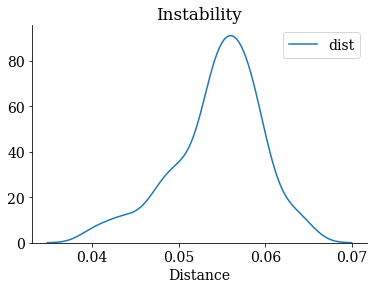

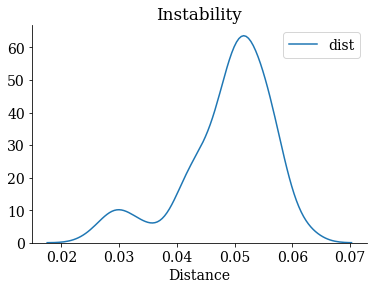

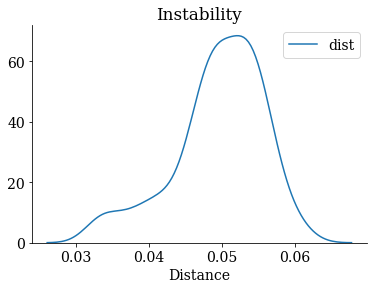

In [9]:
# Plot Instability for each device
for i, tab in enumerate(inst_table):
    # Plot KDE plot
    sns.kdeplot(tab['dist'])
    # Set plot title
    plt.title(f'Instability')
    # Hide top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Distance')
    # Save the plot
    plt.savefig(f'./results/instability/instability_{i}.png')
    # Show plot
    plt.show()